### Summary: Vision Transformer (ViT) Model

#### **Model Overview**

The Vision Transformer (ViT) model is designed for image classification tasks. It leverages the transformer architecture, originally developed for natural language processing, to handle image data. The model processes images by dividing them into patches, transforming these patches into a format suitable for transformers, and then applying self-attention mechanisms to capture relationships between patches.

#### **Methodology**

1. **Patch Extraction:**
   - **Purpose:** Convert an image into a sequence of patches.
   - **Mechanism:** The `PatchExtract` layer splits the input image into non-overlapping patches of a specified size. Each patch is then flattened into a vector. This transformation allows the model to treat patches as sequences of tokens, similar to words in NLP transformers.

2. **Embedding:**
   - **Purpose:** Map patches into a high-dimensional space.
   - **Mechanism:** The flattened patch vectors are passed through a dense layer to project them into an embedding space. This embedding space captures the features of the patches that will be processed by the transformer blocks.

3. **Transformer Blocks:**
   - **Purpose:** Capture complex relationships between patches.
   - **Mechanism:** Each `TransformerBlock` consists of multi-head self-attention and a feed-forward network. The attention mechanism allows the model to focus on different patches and learn dependencies between them. The feed-forward network further processes these dependencies. Multiple transformer blocks are stacked to enhance the model's ability to capture hierarchical and complex patterns.

4. **Global Average Pooling:**
   - **Purpose:** Aggregate information from all patches.
   - **Mechanism:** After passing through the transformer blocks, global average pooling is applied to reduce the sequence of patch embeddings to a single vector by averaging the features across all patches.

5. **Classification:**
   - **Purpose:** Predict class probabilities.
   - **Mechanism:** The final feature vector is passed through a dense layer with a softmax activation function to output class probabilities, which are used for classification.

#### **Parameters**

1. **Image Dimensions:**
   - **`img_height = 256`**
   - **`img_width = 256`**
   - **Rationale:** Size of the input images. 256x256 is a common choice that balances detail and computational efficiency.

2. **Number of Classes:**
   - **`num_classes = 4`**
   - **Rationale:** Number of distinct categories for classification.

3. **Patch Size:**
   - **`patch_size = 16`**
   - **Rationale:** Size of the patches extracted from the images. A smaller patch size like 16 allows the model to capture finer details but increases the number of patches, which can add computational complexity.

4. **Embedding Dimension:**
   - **`embed_dim = 64`**
   - **Rationale:** Dimension of the embedding space for patches. 64 is a moderate size that captures sufficient feature information while being computationally manageable.

5. **Number of Attention Heads:**
   - **`num_heads = 4`**
   - **Rationale:** Number of attention heads in the multi-head attention mechanism. 4 heads allow the model to capture diverse aspects of the patch relationships and is a good balance between complexity and computational efficiency.

6. **Feed-Forward Dimension:**
   - **`ff_dim = 128`**
   - **Rationale:** Size of the hidden layers in the feed-forward network. 128 supports complex feature transformations without excessive computation.

7. **Number of Transformer Blocks:**
   - **`num_blocks = 4`**
   - **Rationale:** Number of transformer blocks stacked in the model. 4 blocks provide a good balance of depth and complexity, capturing hierarchical features while managing computational demands.

#### **Conclusion**

The Vision Transformer (ViT) model uses a transformer-based approach for image classification by converting images into sequences of patches, embedding these patches, and applying transformer blocks to capture complex patterns. The chosen parameters are designed to balance model capacity, computational efficiency, and the ability to learn meaningful representations from the image data. Adjusting these parameters based on specific tasks and datasets can further optimize the model’s performance.

### Lets Build VIT Model

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Flatten, Embedding, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Define PatchExtract Layer
class PatchExtract(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    @tf.function
    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]
        channels = tf.shape(images)[3]

        patches = tf.image.extract_patches(images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patch_size = self.patch_size * self.patch_size * channels
        patches = tf.reshape(patches, [batch_size, -1, patch_size])
        return patches

# Define TransformerBlock Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    @tf.function
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Vision Transformer Model
def build_vit_model(img_height, img_width, num_classes, patch_size=16, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=4):
    inputs = Input(shape=(img_height, img_width, 3))
    x = PatchExtract(patch_size)(inputs)
    x = Dense(embed_dim)(x)
    
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    x = tf.reduce_mean(x, axis=1)  # Global average pooling
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# Parameters
img_height = 256
img_width = 256
num_classes = 4  # Number of classes in your dataset
patch_size = 16
embed_dim = 64
num_heads = 4
ff_dim = 128
num_blocks = 4

# Build and compile the model
vit_model = build_vit_model(img_height, img_width, num_classes, patch_size, embed_dim, num_heads, ff_dim, num_blocks)
vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
vit_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 patch_extract_3 (PatchExtr  (None, None, 768)         0         
 act)                                                            
                                                                 
 dense (Dense)               (None, None, 64)          49216     
                                                                 
 transformer_block (Transfo  (None, None, 64)          83200     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, None, 64)          83200     
 formerBlock)                                                    
                                                             

In [8]:
# Directory paths
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease(Potato)",
    shuffle=True,
    image_size= (img_height, img_width),
    batch_size= batch_size
)

Found 2152 files belonging to 3 classes.


In [42]:
class_names = dataset.class_names

In [43]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

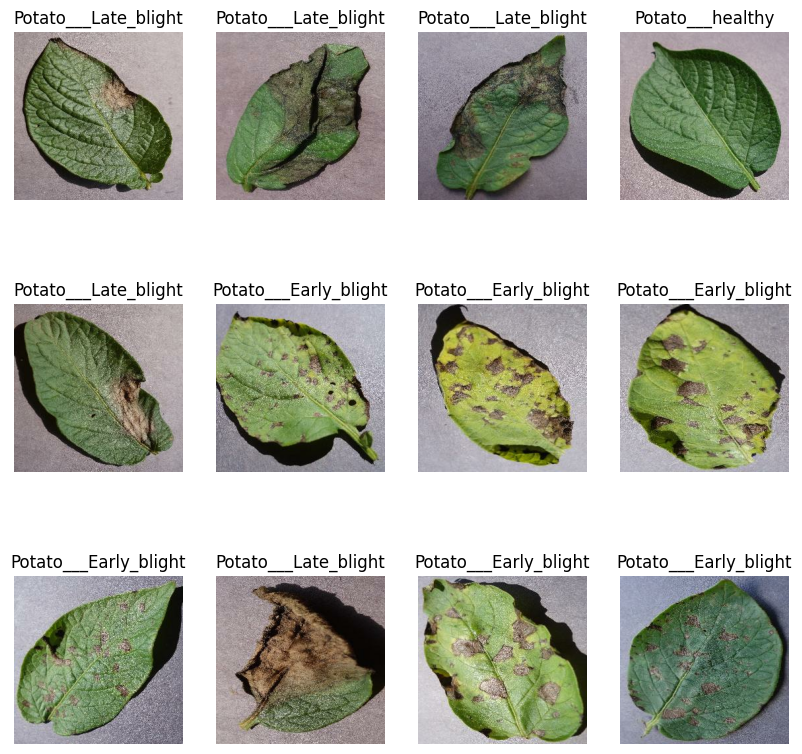

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(image, label):
    image = normalization_layer(image)
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Optionally, cache and prefetch to optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Inspect dataset
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Labels: [0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0]


In [16]:
# Train the model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Set the number of epochs based on your requirements
)

# Save the model if needed
vit_model.save('vit_model.h5')

vit_model.summary()

Epoch 1/10
54/54 [==============================] - 244s 4s/step - loss: 0.3029 - accuracy: 0.8920 - val_loss: 0.3431 - val_accuracy: 0.8646
Epoch 2/10
54/54 [==============================] - 213s 4s/step - loss: 0.2753 - accuracy: 0.9067 - val_loss: 0.3302 - val_accuracy: 0.8646
Epoch 3/10
54/54 [==============================] - 179s 3s/step - loss: 0.2610 - accuracy: 0.9032 - val_loss: 0.2307 - val_accuracy: 0.9115
Epoch 4/10
54/54 [==============================] - 81s 2s/step - loss: 0.1968 - accuracy: 0.9349 - val_loss: 0.1354 - val_accuracy: 0.9479
Epoch 5/10
54/54 [==============================] - 144s 3s/step - loss: 0.2190 - accuracy: 0.9190 - val_loss: 0.3300 - val_accuracy: 0.8594
Epoch 6/10
54/54 [==============================] - 107s 2s/step - loss: 0.1865 - accuracy: 0.9343 - val_loss: 0.1268 - val_accuracy: 0.9688
Epoch 7/10
54/54 [==============================] - 74s 1s/step - loss: 0.1761 - accuracy: 0.9390 - val_loss: 0.1235 - val_accuracy: 0.9479
Epoch 8/10
54/5

C:\Users\joshu\miniforge3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 patch_extract_3 (PatchExtr  (None, None, 768)         0         
 act)                                                            
                                                                 
 dense (Dense)               (None, None, 64)          49216     
                                                                 
 transformer_block (Transfo  (None, None, 64)          83200     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, None, 64)          83200     
 formerBlock)                                                    
                                                                 
 transform

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

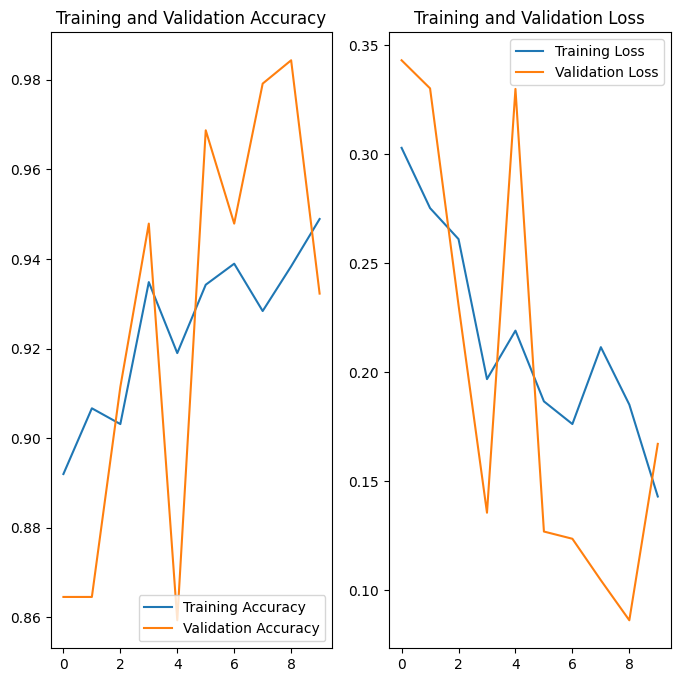

In [25]:
EPOCH = 10
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to Predict
first image actual Label: Potato___Late_blight
1/1 [==============================] - 1s 672ms/step
Predicted Label: Potato___Late_blight


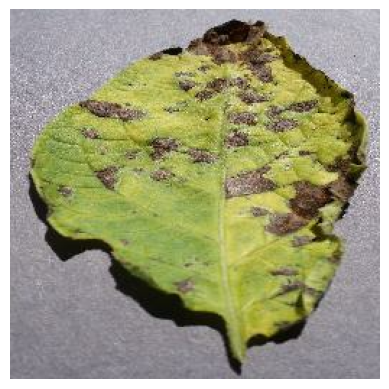

In [36]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    # Scale image data to [0, 255] and convert to uint8
    first_image = (image_batch[i] * 255).numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('first image to Predict')
    plt.imshow(first_image)
    print("first image actual Label:", class_names[first_label])
    plt.axis("off")

batch_prediction = vit_model.predict(image_batch)
print('Predicted Label:', class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create batch

    prediction = model.predict(img_array)

    Predicted_class = class_names[np.argmax(prediction[0])]
    Confidence = round(100*(np.max(prediction[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 90ms/step


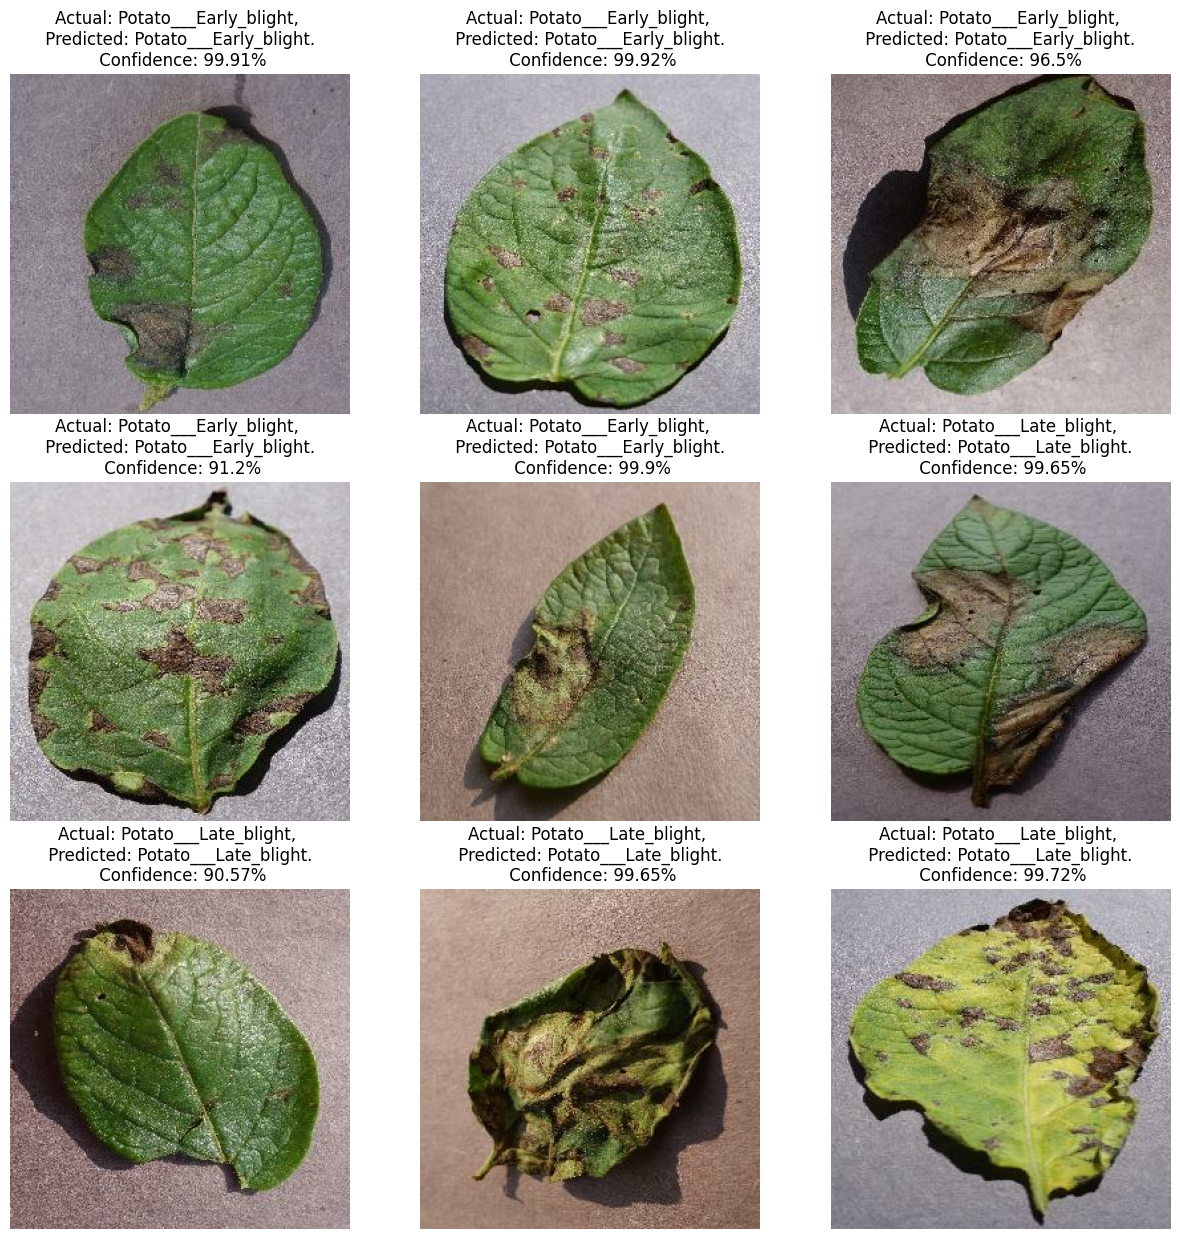

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = (image_batch[i] * 255).numpy().astype('uint8')
        plt.imshow(image)

        Predicted_class, Confidence = predict(vit_model, images[i].numpy())
        Actual_class = class_names[labels[i]]

        plt.title(f"Actual: {Actual_class}, \n Predicted: {Predicted_class}. \n Confidence: {Confidence}%")
        plt.axis("off")

In [40]:
vit_model.evaluate(test_ds)

8/8 [==============================] - 8s 669ms/step - loss: 0.1702 - accuracy: 0.9609


[0.17020153999328613, 0.9609375]

In [47]:
import numpy as np
import tensorflow as tf

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Iterate through the validation dataset
for image_batch, label_batch in val_ds:
    # Make predictions
    preds = vit_model.predict(image_batch)
    preds_labels = np.argmax(preds, axis=-1)
    
    # Extend lists
    true_labels.extend(label_batch.numpy())
    predictions.extend(preds_labels)

# Convert lists to numpy arrays for compatibility with scikit-learn
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 [==============================] - 1s 1s/step


In [51]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert the report to a DataFrame for better readability
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)


                       precision    recall  f1-score     support
Potato___Early_blight   1.000000  0.924731  0.960894   93.000000
Potato___Late_blight    0.865979  1.000000  0.928177   84.000000
Potato___healthy        1.000000  0.600000  0.750000   15.000000
accuracy                0.932292  0.932292  0.932292    0.932292
macro avg               0.955326  0.841577  0.879690  192.000000
weighted avg            0.941366  0.932292  0.930104  192.000000


### Summary of the Classification Report

**Overall Performance:**
- **Accuracy:** 93.2%  
  The model correctly classifies 93.2% of all instances across all classes, indicating strong overall performance.

**Per-Class Performance:**
- **Potato___Early_blight:**
  - **Precision:** 100%  
    All predictions for this class are correct.
  - **Recall:** 92.4%  
    The model identifies 92.4% of all actual instances of this class.
  - **F1-Score:** 96.1%  
    Excellent balance between precision and recall for this class.

- **Potato___Late_blight:**
  - **Precision:** 86.6%  
    86.6% of predictions for this class are correct.
  - **Recall:** 100%  
    The model identifies all actual instances of this class.
  - **F1-Score:** 92.8%  
    Strong performance with a good balance between precision and recall.

- **Potato___healthy:**
  - **Precision:** 100%  
    All predictions for this class are correct.
  - **Recall:** 60%  
    The model identifies 60% of all actual instances of this class.
  - **F1-Score:** 75%  
    Reasonable performance, but improvement is needed, especially in identifying all instances of this class.

**Averages:**
- **Macro Average:**
  - **Precision:** 95.5%  
    Average precision across all classes, treating each class equally.
  - **Recall:** 84.2%  
    Average recall across all classes.
  - **F1-Score:** 87.9%  
    Average F1-score, balancing precision and recall across all classes.

- **Weighted Average:**
  - **Precision:** 94.1%  
    Average precision weighted by the number of instances per class.
  - **Recall:** 93.2%  
    Average recall weighted by the number of instances per class.
  - **F1-Score:** 93.0%  
    Average F1-score, considering class imbalance.

### Key Insights:
- **Strengths:** The model performs exceptionally well on most classes, especially `Potato___Early_blight` and `Potato___Late_blight`, with high precision and recall.
- **Areas for Improvement:** The `Potato___healthy` class has lower recall, indicating that the model misses some instances of this class. Additional efforts are needed to enhance performance on this class.
- **Balanced Performance:** The weighted and macro averages show a generally balanced performance across classes, though precision and recall vary by class.

Overall, the model is effective but could be further optimized to improve recall, especially for less represented classes.

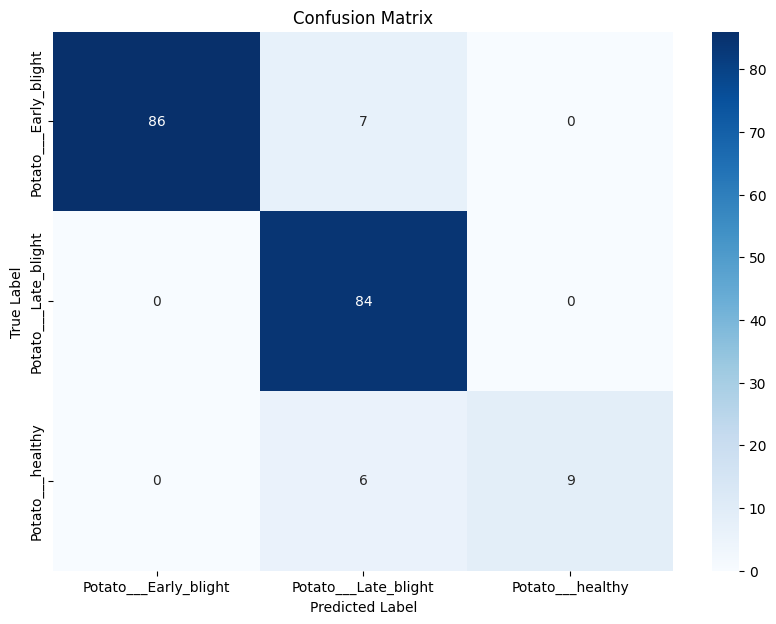

In [55]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Potential Improvements for Vision Transformer (ViT) Model

**Model Architecture:**
- **Enhance Capacity:** Consider increasing the number of transformer blocks or the embedding dimension to capture more complex patterns and features.
- **Advanced Variants:** Explore hierarchical Vision Transformers or hybrid models that combine convolutional and transformer layers to improve feature extraction and representation.

**Training Techniques:**
- **Data Augmentation:** Implement various data augmentation techniques, such as random rotations, flips, and color adjustments, to enrich the training dataset and improve model generalization.
- **Regularization:** Apply regularization methods like dropout and weight decay to prevent overfitting and enhance model robustness.
- **Learning Rate Adjustments:** Utilize learning rate scheduling, including warm-up and decay strategies, to optimize the training process and achieve better convergence.

**Data and Computational Efficiency:**
- **Data Augmentation:** Apply real-time augmentation during training to increase data variability without additional storage requirements.
- **Mixed Precision Training:** Use mixed precision training to accelerate model training and reduce memory usage, which can be beneficial for large-scale models.

**Evaluation and Fine-Tuning:**
- **Cross-Validation:** Employ cross-validation techniques to gain a more reliable evaluation of the model’s performance across different subsets of the data.
- **Hyperparameter Tuning:** Systematically adjust hyperparameters to find the optimal settings for your model.
- **Model Ensembling:** Combine predictions from multiple models to enhance accuracy and robustness.

These strategies can help refine the model’s performance and address any issues related to accuracy or generalization.

In [19]:
# Load and preprocess data
#from tensorflow.keras.preprocessing import image_dataset_from_directory

# Directory paths
#data_dir = 'Plant Disease(Potato)'
#batch_size = 32


# Load training and validation datasets
#train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   # data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=123,
    #image_size=(img_height, img_width),
    #batch_size=batch_size
#)

#val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    #data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=123,
    #image_size=(img_height, img_width),
    #batch_size=batch_size
#)

# Access and print class names
#class_names = train_ds.class_names
#print(f"Class names: {class_names}")
# Normalize pixel values to [0, 1]
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#def preprocess(image, label):
    #image = normalization_layer(image)
   #return image, label

#train_ds = train_ds.map(preprocess)
#val_ds = val_ds.map(preprocess)

# Optionally, cache and prefetch to optimize performance
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Inspect dataset
#for image_batch, label_batch in train_ds.take(1):
    #print(f"Image batch shape: {image_batch.shape}")
    #print(f"Label batch shape: {label_batch.shape}")
    #print(f"Labels: {label_batch.numpy()}")
